# Rede Neural Recorrente - Série Temporal com 1 previsor

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models

%matplotlib inline

## Obter os dados de treino

In [5]:
data_train = pd.read_csv("petr4_treinamento_ex.csv")

In [6]:
data_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


## Pré-Processamento dos dados de treino - Apagar dados Ausentes

In [7]:
# Só existem valores ausentes nos dados de treino
data_train.isnull().sum()

Date         0
Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64

In [8]:
# Tamanho original do dataset de treino
data_train.shape

(1345, 7)

In [9]:
# Como apenas 3 linhas têm valores ausentes optou-se por apagar essas linhas.
data_train = data_train.dropna()

In [10]:
# Confirmação de ter-se removido apenas 3 linhas
data_train.shape

(1342, 7)

In [11]:
# Confirmação da anão existencia de valores nulos
data_train.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Pré-Processamento dos dados de treino- Normalização das Variaveis

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
# Nas redes neurais recorrentes, como cada neuronio aponta para ele mesmo(possui loops), ou seja, o valor da função de ativação 
# é passado para as camadas subsequentes e também para a própria camada. Assim sendo a rede neural recorrente pode ser 
# considerada como várias cópias de si mesma. 
# Utiliza-se a normalização para que o poder computacional necessário não seja tão grande.

# StandardScaler: Assume que as variaveis seguem uma distribuição normal. Após a normalização o desvio padrão das variaveis
# será 1 e a media 0. É util quando se têm valores negativos. Após a sua aplicação todas as variaveis têm a mesma escala.

# MinMaxScaler: Espreme as variaveis numa escala de -1 a 1 (se existirem valores negativos). É utilizado quando a distribuição
# não é gausiana. Funciona bem se o desio padrão for pequeno e é sensivel a outliers.

scaler = MinMaxScaler(feature_range=(0,1))

In [14]:
# Normalizar a variavel de entrada
# Apenas se vai normalizar a variavel Open, porque irá ser a unica variavel de entrada utilizada para fazer o treino do modelo.
scaler.fit(data_train.drop(["Date", "High", "Low", "Close", "Adj Close", "Volume"], axis=1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [15]:
# Array com a variavel Open normalizada
open_norm_train = scaler.fit_transform(data_train.drop(["Date", "High", "Low", "Close", "Adj Close", "Volume"], axis=1))

## Divisão dos dados de treino

In [16]:
# Utilizar apenas o preço de abertura para prever o preço das acções.
open_norm_train[0:5]

array([[0.68207343],
       [0.67429801],
       [0.69676026],
       [0.70323974],
       [0.68725706]])

In [17]:
# Prever o preço das acções com base nos preços de abertura nos 90 dias anteriores.

X_train = [] # vector com os preços nos 90 dias anteriores.
y_train = [] # vector com o preço da acção no dia 91.

In [18]:
# Só é possivel prever o preço das acções desde o dia 90 até ao dia 1242. Porque só se tem registro de 1242 dias e 
# estabeleceu-se como critério utilizar os 90 dias anteriores para fazer uma previsão.

for i in range(90, 1242):
    X_train.append(open_norm_train[i-90:i,0])
    y_train.append(open_norm_train[i, 0])

In [19]:
# Converter os vectores em arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [20]:
X_train.shape

(1152, 90)

In [21]:
# X_train[0]: preço nos primeiros 90 dias. Utilizado para prever o preço no dia 91.
# X_train[1]: preços entre o dia 1 e dia 91. Utilizado para prever o preço no dia 92.
# X_train[2]: preço entre o dia 2 e dia 92. Utilizado para prever o preço no dia 93.

X_train[0,84:89]

array([0.69330454, 0.68941685, 0.67429801, 0.66220307, 0.66090713])

In [22]:
# y_train[0:1]: preço no dia 91.
# y_train[1:2] preço no dia 92.
y_train[2:3]

array([0.69071279])

In [23]:
# A camada de entrada tem de ser um tensor 3d (input_shape, timesteps, input_dim)
# input_shape: 1152 registros. Número de registros totais
# timesteps: 90 registros. Número de registros utilizados para fazer a previsão.
#input_dim: 1 indicador(apenas 1 variavel de entrada)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [24]:
X_train.shape

(1152, 90, 1)

## Modelo Rede Neural Recorrente

In [25]:
# sequential - A informação é passada de uma camada para a camada seguinte

#-------------------------------------------------------------------------------------------------------------------------------
# Camada LSTM

# LSTM - Long short term memory. AS redes neurais simples têm dificuldade em "aprender" alguns tipos de padrões mais complexos.
# Nesses casos pode-se utilizar o tipo de rede neural recorrente LSTM que aprende "dependencias" de longo prazo.

# As redes neurais recorrentes simples armazenam as informações no tempo atraves de loops( o neuronio apenas aponta para ele 
# mesmo e para a camada seguinte). Isto permte que a informação persista.
# As redes neurais recorrentes LSTM para alem disso têm celulas de memoria e manipulam essas celulas de modo a filtrar e 
# armazenar a informação importante nessas celulas.

# As redes neurais recorrentes ajudam no problema do gradiente desaparecendo(vanish gradient). No ajuste dos pesos ao se
# utilizar a descida do gradiente e a sua actualização atraves de backpropagation em primeiro faz-se os calculos da camada
# de entrada para a camada de saida. Os pesos são depois actalizados a partir da camada de saida para a camada de entrada. Os
# pesos vão sendo actualizados utilizando o learning rate(maiores alterações nas 1ªs camadas). Caso se tenha muitos loops
# as ultimas actualizações do gradiente são muito pequenas, o que faz com que o peso não tenha alteração no seu valor.

# Número de celulas de memoria(units): Número de vezes(loops) em que a informação é passada ao mesmo neuronio e a camada 
# seguinte (numero de cópias da camada). Deve ser um valor alto para adicinonar mais dimensionalidade e decorar a tendencia ao 
# longo do tempo.

# Return_sequence: True. Apenas se utilizada quando se tem mais de uma camada LSTM. Indica que a informação será passada para a
# camada seguinte.

# input_shape: Número de registros utilizados para fazer a previsão(90) e número de variaveis de entrada(1).
#-------------------------------------------------------------------------------------------------------------------------------
# Camada densa

# Todos os neuronios da ultima camada( segunda camada LSTM) estão conectados à camada de saida. Nas camadas LSTM isso tambem
# acontece.

# units: 1. Só se quer prever o valor Open.
# activation: linear. É um problema de regressão. Como os valores estão normalizados(entre 0 e 1) caso se utiliza-se a função
# sigmoid tambem se retornaria valores entre 0 e 1.
#-------------------------------------------------------------------------------------------------------------------------------

model = models.Sequential()
model.add(layers.LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(units=1, activation="linear"))

## Compilação e Ajuste do modelo RNN

In [26]:
# optimizer: pode-se utilizar o RMSprop, indicado para redes neurais recorrentes, ou o adam que obtem resultados semelhantes.
# loss: mean_squared_error é o parametro utilizado para problemas de regressão.

# Compilação do modelo
model.compile(optimizer="rmsprop", loss="mean_squared_error", metrics=["mean_absolute_error"])

In [27]:
# Ajustar os dados de entrada de treino aos dados de saida para treinar o modelo.
model.fit(X_train, y_train, epochs=50, batch_size=32)

Train on 1152 samples
Epoch 1/50
1152/1152 [==============================] - 11s 10ms/sample - loss: 0.0266 - mean_absolute_error: 0.1199
Epoch 2/50
1152/1152 [==============================] - 9s 8ms/sample - loss: 0.0124 - mean_absolute_error: 0.0865
Epoch 3/50
1152/1152 [==============================] - 8s 7ms/sample - loss: 0.0113 - mean_absolute_error: 0.0823
Epoch 4/50
1152/1152 [==============================] - 8s 7ms/sample - loss: 0.0092 - mean_absolute_error: 0.0746
Epoch 5/50
1152/1152 [==============================] - 8s 7ms/sample - loss: 0.0079 - mean_absolute_error: 0.0693
Epoch 6/50
1152/1152 [==============================] - 8s 7ms/sample - loss: 0.0082 - mean_absolute_error: 0.0695
Epoch 7/50
1152/1152 [==============================] - 8s 7ms/sample - loss: 0.0072 - mean_absolute_error: 0.0648
Epoch 8/50
1152/1152 [==============================] - 8s 7ms/sample - loss: 0.0064 - mean_absolute_error: 0.0624
Epoch 9/50
1152/1152 [==============================] - 

## Obter os dados de teste

In [41]:
data_test = pd.read_csv("petr4_teste_ex.csv")

In [42]:
data_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-28,19.200001,19.200001,16.910000,16.910000,16.910000,134504900
1,2018-05-29,18.000000,19.440001,17.600000,19.299999,19.299999,181509800
2,2018-05-30,18.389999,19.969999,18.129999,18.980000,18.980000,125430000
3,2018-06-01,19.559999,19.750000,14.900000,16.160000,16.160000,216954700
4,2018-06-04,17.290001,17.639999,17.049999,17.530001,17.530001,93547600


In [43]:
data_test.shape

(19, 7)

In [44]:
# data_train tem os dados desde 2013-01-02 até 2017-12-29
# data_teste tem os dados desde 2018-01-02 até 2018-01-31
# data tem dos dados desde 2013-01-02 até 2018-01-31

data = pd.concat((data_train["Open"], data_test["Open"]), axis=0)
#data_data = pd.concat((data_train["Date"], data_test["Date"]), axis=0)
#data = pd.DataFrame({"Data":data_data, "Open":data_open})
#data.head()

In [45]:
# dados desde 2017-08-28 até 2018-01-31
data_open_test = data[len(data)-len(data_test)-90:].values

In [46]:
# 19+90=109 dias de preços
# O X_test contem os 22 dias da base de dados de teste mais os 90 dias anteriores. Esses 90 dias anteriores são necessários 
# para se poderem fazer previssões.
len(data_open_test)

109

In [47]:
data_open_test.shape

(109,)

In [48]:
# Alterar a forma do array para poder ser utilizada a normalização
# -1 significa que o array não tem colunas
data_open_test = data_open_test.reshape(-1,1)

In [49]:
data_open_test.shape

(109, 1)

## Pré-Processamento dos dados de teste - Normalização das Variaveis

In [50]:
# Array com a variavel Open normalizada.
# Não é necessário o fit_transform porque os dados já foram ajustados anteriormente na outra normalização.

open_norm_test = scaler.transform(data_open_test)

## Divisão dos dados de teste

In [63]:
X_test = []
y_test = []

In [64]:
for i in range(90, 109):
    X_test.append(open_norm_test[i-90:i, 0])
    y_test.append(open_norm_test[i,0])

In [65]:
# Converter os vectores em arrays
X_test, y_test = np.array(X_test), np.array(y_test)

In [66]:
# X_test[0]: preço nos primeiros 90 dias. Utilizado para prever o preço no dia 91.
# X_test[1]: preços entre o dia 1 e dia 91. Utilizado para prever o preço no dia 92.
# X_test[2]: preço entre o dia 2 e dia 92. Utilizado para prever o preço no dia 93.

X_test[1,89]

0.6479482073434125

In [67]:
# y_test[0:1]: preço no dia 91.
# y_test[1:2] preço no dia 92.

y_test[0:1]

array([0.64794821])

In [68]:
# A camada de entrada tem de ser um tensor 3d (input_shape, timesteps, input_dim)
# input_shape: 19 registros. Número de registros totais de teste
# timesteps: 90 registros. Número de registros utilizados para fazer a previsão.
#input_dim: 1 indicador(apenas 1 variavel de entrada)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [69]:
X_test.shape

(19, 90, 1)

## Previsão e Avaliação do Modelo RNN

In [70]:
# Prever os dados de teste para avaliar o modelo
predictions = model.predict(X_test)

In [71]:
# Reverter a normalização do X_test para comparar os valores das acções
predictions = scaler.inverse_transform(predictions)

In [72]:
# Reverter a normalização do y_test para comparar os valores das acções
# Alterar a forma do array para poder reverter a normalização
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [73]:
pd.DataFrame({"Predictions": predictions[:,0], "y_test":y_test[:,0]}).head()

,Predictions,y_test
0,20.186380,19.200001
1,19.314875,18.000000
2,18.750294,18.389999
3,18.492102,19.559999
4,18.891275,17.290001


### Avaliação do Modelo

In [74]:
from sklearn import metrics

In [75]:
# O MSE é muito mais elevado porque penaliza os desvios grandes(são elevados ao quadrado).
# O MAE de 0.88 significa que o preço das acções varia +- 0.88 reais. 
print("MAE", metrics.mean_absolute_error(y_test, predictions))
print("MSE", metrics.mean_squared_error(y_test, predictions))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE 0.8770988576210424
MSE 0.9095797654403155
RMSE 0.9537189132235533


In [76]:
predictions.mean()

16.936283

In [77]:
y_test.mean()

16.379473684210524

### Resíduos

Text(0.5, 0, 'y_test-predictions')

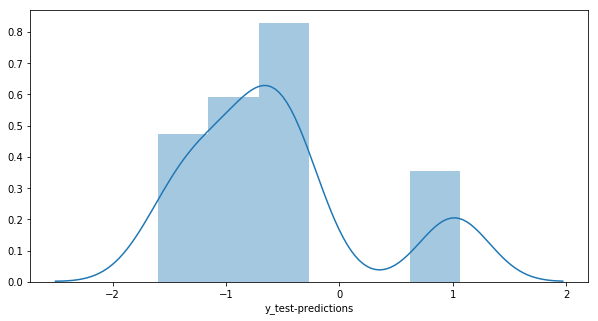

In [78]:
# Histograma de Residuos 
# O gráfico não parece aproximar-se de uma distriuição normal, onde os residuos são proximos de zero.

plt.figure(figsize=(10,5))
sns.distplot(y_test-predictions)
plt.xlabel("y_test-predictions")

### Gráfico preço real vs preço previsto

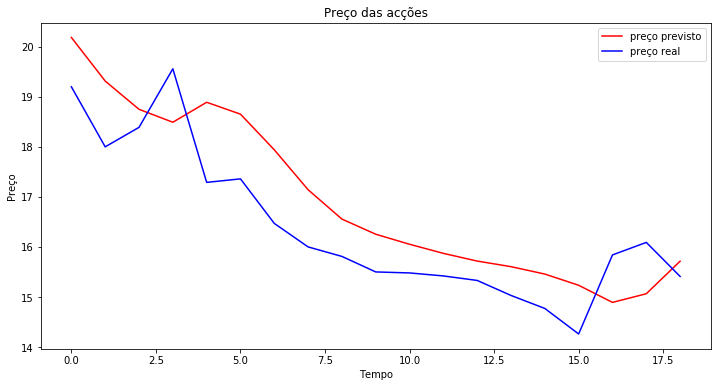

In [79]:
plt.figure(figsize=(12,6))
plt.plot(predictions, color="red", label="preço previsto")
plt.plot(y_test, color="blue", label="preço real")
plt.title("Preço das acções")
plt.xlabel("Tempo")
plt.ylabel("Preço")
plt.legend()
plt.show()